## 分形曲线之koch curve

### turtle实验

In [1]:
import turtle
def koch(t,n): 
    #定义一个函数 科赫曲线，完成绘画功能
    if n < 5 :
        t.fd(n) 
        return
    m = n/3
    koch(t,m)
    t.lt(60)
    koch(t,m)
    t.rt(120)
    koch(t,m)
    t.lt(60)
    koch(t,m)
 
def snowflake(t, n):
    # 画一朵雪花，每一边都是一个科赫曲线
    # for i in range(1):
    koch(t,n)
    t.rt(120)
 

In [2]:
bob = turtle.Turtle()
bob.color('black')
bob.penup() # 画笔提起（不能画）
bob.goto(-150,90) #去到这个点
bob.pendown() # 画笔落下（开始画）
snowflake(bob,300) # 调用函数开始画雪花
snowflake(bob,300) # 调用函数开始画雪花
snowflake(bob,300) # 调用函数开始画雪花
turtle.mainloop() 

### matplotlib实验

#### 包导入与基础函数定义

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import copy

def rotate(p, d):
    """返回**向量p**绕原点逆时针旋转d度的坐标"""
    a = np.radians(d)
    m = np.array([[np.cos(a), np.sin(a)],[-np.sin(a), np.cos(a)]])
    return p @ m # np.dot(p,m)

def koch_curve(p, q):
    """将线段pq生成科赫曲线，返回uvw三个点"""
    p, q = np.array(p), np.array(q)
    u = p + (q-p)/3 # 三等分点u的坐标
    v = q - (q-p)/3 # 三等分点V的坐标
    w = rotate(v-u, 60) + u # 线段uv绕u点逆时针旋转60°得到点w的坐标
    
    return u.tolist(), v.tolist(), w.tolist()
    
def snow(triangle, k):
    """给定三角形，生成封闭的科赫雪花"""
    
    for i in range(k):# 处理每条曲线，处理k次
        result = []
        t_len = len(triangle)
        # print(triangle)
        for j in range(t_len):
            p = triangle[j]
            q = triangle[(j+1)%t_len]
            # print(p)
            u, v, w = koch_curve(p, q)
            result.extend([p, u, w, v])
        # triangle = copy.deepcopy(result)
        triangle = result.copy() # 内部对象不会修改，使用浅拷贝即可
        # print(result)
    
    triangle.append(triangle[0])
    return triangle


#### 普通绘制

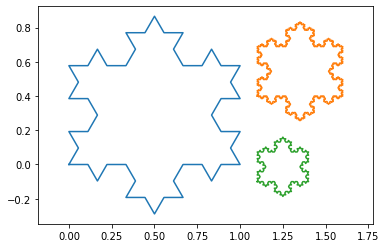

In [11]:
def plot_snow(snow_list):
    """绘制雪花"""
    
    for triangle, k in snow_list:
        data = np.array(snow(triangle, k))
        x, y = np.split(data, [1], axis=1)
        # print(data,x,y)
        plt.plot(x, y)
    
    plt.axis('equal') 
    plt.show()

snow_list = [
    ([(0,0), (0.5,0.8660254), (1,0)], 2),
    ([(1.1,0.4), (1.35,0.8330127), (1.6,0.4)], 4),
    ([(1.1,-0.1), (1.25,0.15980761), (1.4,-0.1)], 3)
]
plot_snow(snow_list)


#### 动态绘制一个并保存
见py文件

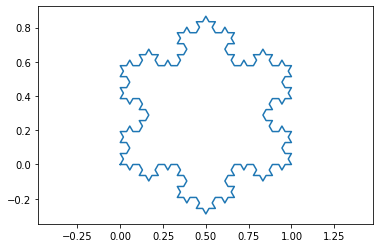

In [6]:
def plot_snow(snow_list):
    """返回雪花数组"""
    ret = []
    for triangle, k in snow_list:
        data = np.array(snow(triangle, k))
        x, y = np.split(data, [1], axis=1)
        ret.append((x,y))
    return ret

snow_list = [
    ([(0,0), (0.5,0.8660254), (1,0)], 3),
    ([(1.1,0.4), (1.35,0.8330127), (1.6,0.4)], 4),
    ([(1.1,-0.1), (1.25,0.15980761), (1.4,-0.1)], 3)
]
fig, ax = plt.subplots()
x,y = plot_snow(snow_list[:1])[0]
xlen = len(x)
line, = ax.plot(x,y)


def init():  # only required for blitting to give a clean slate.
    line, = ax.plot(x,[np.nan] * len(x))  # update the data.
    ax.figure.canvas.draw()
    return line,

def animate(i):
    line, = ax.plot(x[0:(i+1)%xlen],y[0:(i+1)%xlen])  # update the data.
    ax.figure.canvas.draw()
    return line,

divide = 4**(3-2) # sum:3*4**k
frames = [i for i in range(0,xlen,divide)]
ani = FuncAnimation(fig, animate, init_func=init, interval=2, blit=True, frames=frames) 

plt.axis('equal') 
plt.show()
ani.save('animation.gif', writer='pillow')

#### 多线程绘制
见py文件

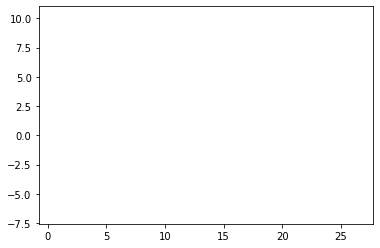

"\nplt.axis('equal') \nplt.show()\n"

In [13]:
import math
import threading
from time import sleep

def build_snow_list(n):
    s = 0
    ret = []
    for i in range(n):
        l = (s+0.5,0)
        r = (s+i+1.5,0)
        m = ((l[0]+r[0])/2,(i+1)/2*math.sqrt(3))
        ret.append(([l,m,r],i))
        # print(l)
        s = s + i + 2
    return ret

def plot_snow(snow_list):
    """返回雪花坐标数组列表"""
    ret = []
    for triangle, k in snow_list:
        data = np.array(snow(triangle, k))
        x, y = np.split(data, [1], axis=1)
        ret.append((k,x,y))
    return ret

fig = plt.figure()
ax = plt.subplot()

pool_size = 6
t = plot_snow(build_snow_list(pool_size))
control = [0] * pool_size
xlen = [len(i[1]) for i in t]
runtime_data_x = [[i[1][0]] for i in t]
runtime_data_y = [[i[2][0]] for i in t]
def animate(_):
    for i in range(pool_size):
        # print(control[i])
        if len(runtime_data_x[i]) < control[i]:
            runtime_data_x[i].extend(t[i][1][len(runtime_data_x[i]):control[i]+1])
            runtime_data_y[i].extend(t[i][2][len(runtime_data_y[i]):control[i]+1])
        else:
            runtime_data_x[i] = list(t[i][1][0:control[i]+1])
            runtime_data_y[i] = list(t[i][2][0:control[i]+1])
        line, = ax.plot(runtime_data_x[i],runtime_data_y[i])
    ax.figure.canvas.draw()
    return line,
    
for i in range(pool_size):
    line, = ax.plot(t[i][1],t[i][2],color='white')
ani = FuncAnimation(fig, animate, interval=2, blit=True)
def dataUpdate_thead(i):
    while True:
        control[i] = (control[i]+1)%xlen[i]
        sleep(0.01)
ad_rdy_ev = threading.Event()
ad_rdy_ev.set()  # 设置线程运行
for i in range(pool_size):
    ti = threading.Thread(target=dataUpdate_thead, args=(i,))
    ti.daemon = True
    ti.start()

plt.axis('equal') 
plt.show()
    
'''
plt.axis('equal') 
plt.show()
'''

### 最终版本
扩展基础定义，把每条线分成4段，模拟慢动作，见py文件。

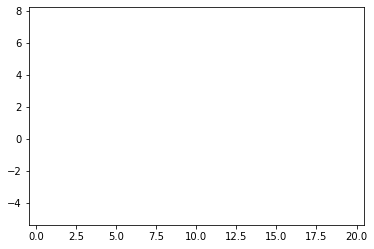

"\nplt.axis('equal') \nplt.show()\n"

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import copy
import math
import threading
from time import sleep

def rotate(p, d):
    """返回**向量p**绕原点逆时针旋转d度的坐标"""
    a = np.radians(d)
    m = np.array([[np.cos(a), np.sin(a)],[-np.sin(a), np.cos(a)]])
    return p @ m # np.dot(p,m)

def koch_curve(p, q):
    """将线段pq生成科赫曲线，返回uvw三个点"""
    p, q = np.array(p), np.array(q)
    u = p + (q-p)/3 # 三等分点u的坐标
    v = q - (q-p)/3 # 三等分点V的坐标
    w = rotate(v-u, 60) + u # 线段uv绕u点逆时针旋转60°得到点w的坐标
    
    return u.tolist(), v.tolist(), w.tolist()
def extend_line(p,q,n):
    """为了模拟慢动作效果，将线段pq扩展成n段，返回中间的点"""
    p, q = np.array(p), np.array(q)
    ret = []
    for i in range(1,n):
        ret.append(p+(q-p)/n*i)
    return [i.tolist() for i in ret]
def snow(triangle, k):
    """给定三角形，生成封闭的科赫雪花"""
    
    for i in range(k):# 处理每条曲线，处理k次
        result = []
        t_len = len(triangle)
        # print(triangle)
        for j in range(t_len):
            p = triangle[j]
            q = triangle[(j+1)%t_len]
            u, v, w = koch_curve(p, q)
            result.extend([p, u, w, v])
        # triangle = copy.deepcopy(result)
        triangle = result.copy() # 内部对象不会修改，使用浅拷贝即可
        # print(result)
    
    triangle.append(triangle[0])
    
    # 分割曲线
    result = []
    t_len = len(triangle)
    for j in range(t_len):
        p = triangle[j]
        q = triangle[(j+1)%t_len]
        result.append(p)
        result.extend(extend_line(p,q,4))
    triangle = result.copy() 
    triangle.append(triangle[0])
    return triangle

def build_snow_list(n):
    s = 0
    ret = []
    for i in range(n):
        l = (s+0.5,0)
        r = (s+i+1.5,0)
        m = ((l[0]+r[0])/2,(i+1)/2*math.sqrt(3))
        ret.append(([l,m,r],i))
        # print(l)
        s = s + i + 2
    return ret

def plot_snow(snow_list):
    """返回雪花坐标数组列表"""
    ret = []
    for triangle, k in snow_list:
        data = np.array(snow(triangle, k))
        x, y = np.split(data, [1], axis=1)
        ret.append((k,x,y))
    return ret

fig = plt.figure()
ax = plt.subplot()

pool_size = 5
t = plot_snow(build_snow_list(pool_size))
control = [0] * pool_size
xlen = [len(i[1]) for i in t]
runtime_data_x = [[i[1][0]] for i in t]
runtime_data_y = [[i[2][0]] for i in t]
def animate(_):
    for i in range(pool_size):
        # print(control[i])
        if len(runtime_data_x[i]) < control[i]:
            runtime_data_x[i].extend(t[i][1][len(runtime_data_x[i]):control[i]+1])
            runtime_data_y[i].extend(t[i][2][len(runtime_data_y[i]):control[i]+1])
        else:
            runtime_data_x[i] = list(t[i][1][0:control[i]+1])
            runtime_data_y[i] = list(t[i][2][0:control[i]+1])
        line, = ax.plot(runtime_data_x[i],runtime_data_y[i])
    ax.figure.canvas.draw()
    return line,
    
for i in range(pool_size):
    line, = ax.plot(t[i][1],t[i][2],color='white')
ani = FuncAnimation(fig, animate, interval=2, blit=True)
def dataUpdate_thead(i):
    while True:
        control[i] = (control[i]+1)%xlen[i]
        sleep(0.03)
ad_rdy_ev = threading.Event()
ad_rdy_ev.set()  # 设置线程运行
for i in range(pool_size):
    ti = threading.Thread(target=dataUpdate_thead, args=(i,))
    ti.daemon = True
    ti.start()

plt.axis('equal') 
plt.show()
    
'''
plt.axis('equal') 
plt.show()
'''